YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Inferred frequency: ME
 Saved as 'gold_uncertainty_dataset_monthly.csv'


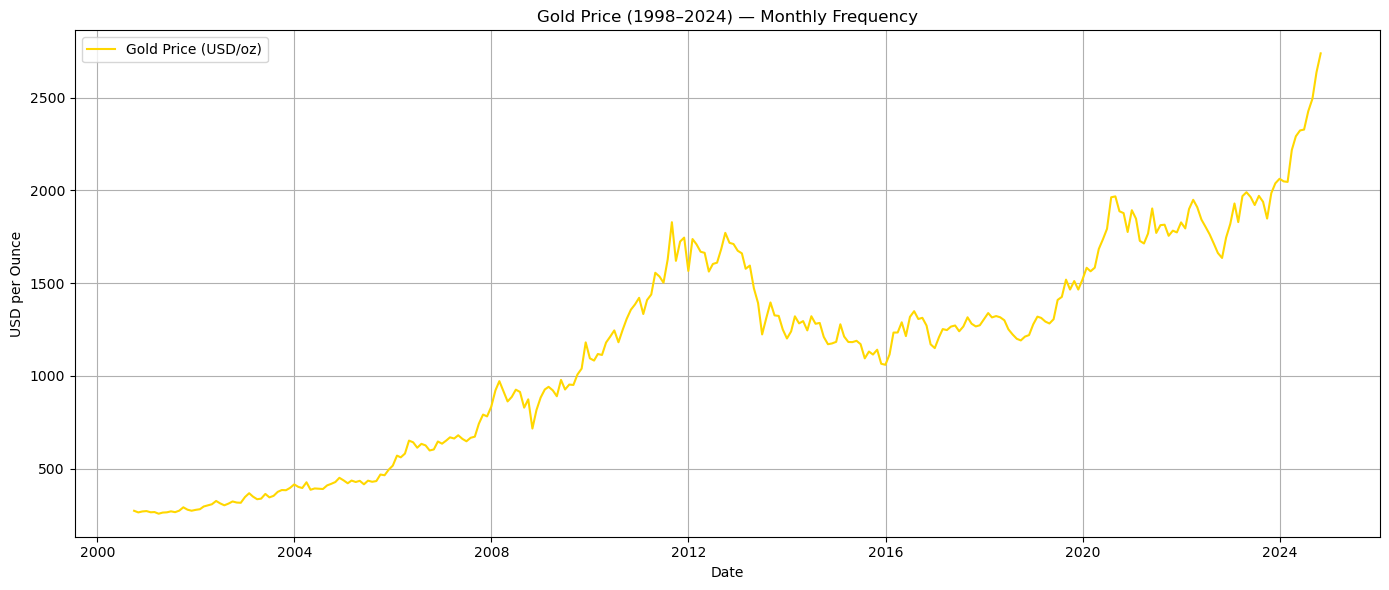

In [2]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import (
    r2_score, mean_absolute_error,
    mean_squared_error, root_mean_squared_error
)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns




# Step 1: Define time range
start = '1998-01-01'
end = '2024-12-31'

# Step 2: Download daily gold prices
gold_raw = yf.download("GC=F", start=start, end=end, interval="1d")

# Flatten multiindex if needed
if isinstance(gold_raw.columns, pd.MultiIndex):
    gold_raw.columns = gold_raw.columns.get_level_values(0)

# Resample gold to month-end
gold = gold_raw['Close'].resample('ME').last()
gold.name = "GoldPriceUSD"

# Step 3: Download GEPU and WUI from FRED and resample to monthly
gepu = web.DataReader('GEPUCURRENT', 'fred', start, end).resample('ME').mean().ffill()
gepu.name = 'GEPU'

wui = web.DataReader('WUIGLOBALSMPAVG', 'fred', start, end).resample('ME').mean().ffill()
wui.name = 'WUI'

# Step 4: Merge and keep only valid rows
merged = pd.concat([gold, gepu, wui], axis=1)
merged.dropna(inplace=True)

# Step 5: Calculate log returns
merged['GoldReturn'] = np.log(merged['GoldPriceUSD'] / merged['GoldPriceUSD'].shift(1))
merged.dropna(inplace=True)

# Step 6: Check frequency
print("Inferred frequency:", merged.index.inferred_freq)

# Step 7: Save dataset
merged_reset = merged.reset_index()  
merged_reset.rename(columns={'index': 'Date'}, inplace=True)  # Fix column name
merged_reset.to_csv("gold_uncertainty_dataset_monthly.csv",index=False)
print(" Saved as 'gold_uncertainty_dataset_monthly.csv'")

# Step 8: Plot
plt.figure(figsize=(14, 6))
plt.plot(merged.index, merged['GoldPriceUSD'], label='Gold Price (USD/oz)', color='gold')
plt.title("Gold Price (1998–2024) — Monthly Frequency")
plt.xlabel("Date")
plt.ylabel("USD per Ounce")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



 Dataset Summary
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 290 entries, 2000-09-30 to 2024-10-31
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GoldPriceUSD     290 non-null    float64
 1   GEPUCURRENT      290 non-null    float64
 2   WUIGLOBALSMPAVG  290 non-null    float64
 3   GoldReturn       290 non-null    float64
dtypes: float64(4)
memory usage: 11.3 KB
None

 Descriptive Statistics
                 count          mean          std           min           25%  \
GoldPriceUSD     290.0   1151.506552   570.759157    257.899994    637.025009   
GEPUCURRENT      290.0    151.922926    75.596392     49.224732     94.764577   
WUIGLOBALSMPAVG  290.0  19026.840069  5386.797722  10474.980000  14169.280000   
GoldReturn       290.0      0.007884     0.046539     -0.198512     -0.021048   

                          50%           75%           max  
GoldPriceUSD      1228.850037   1591.950043   

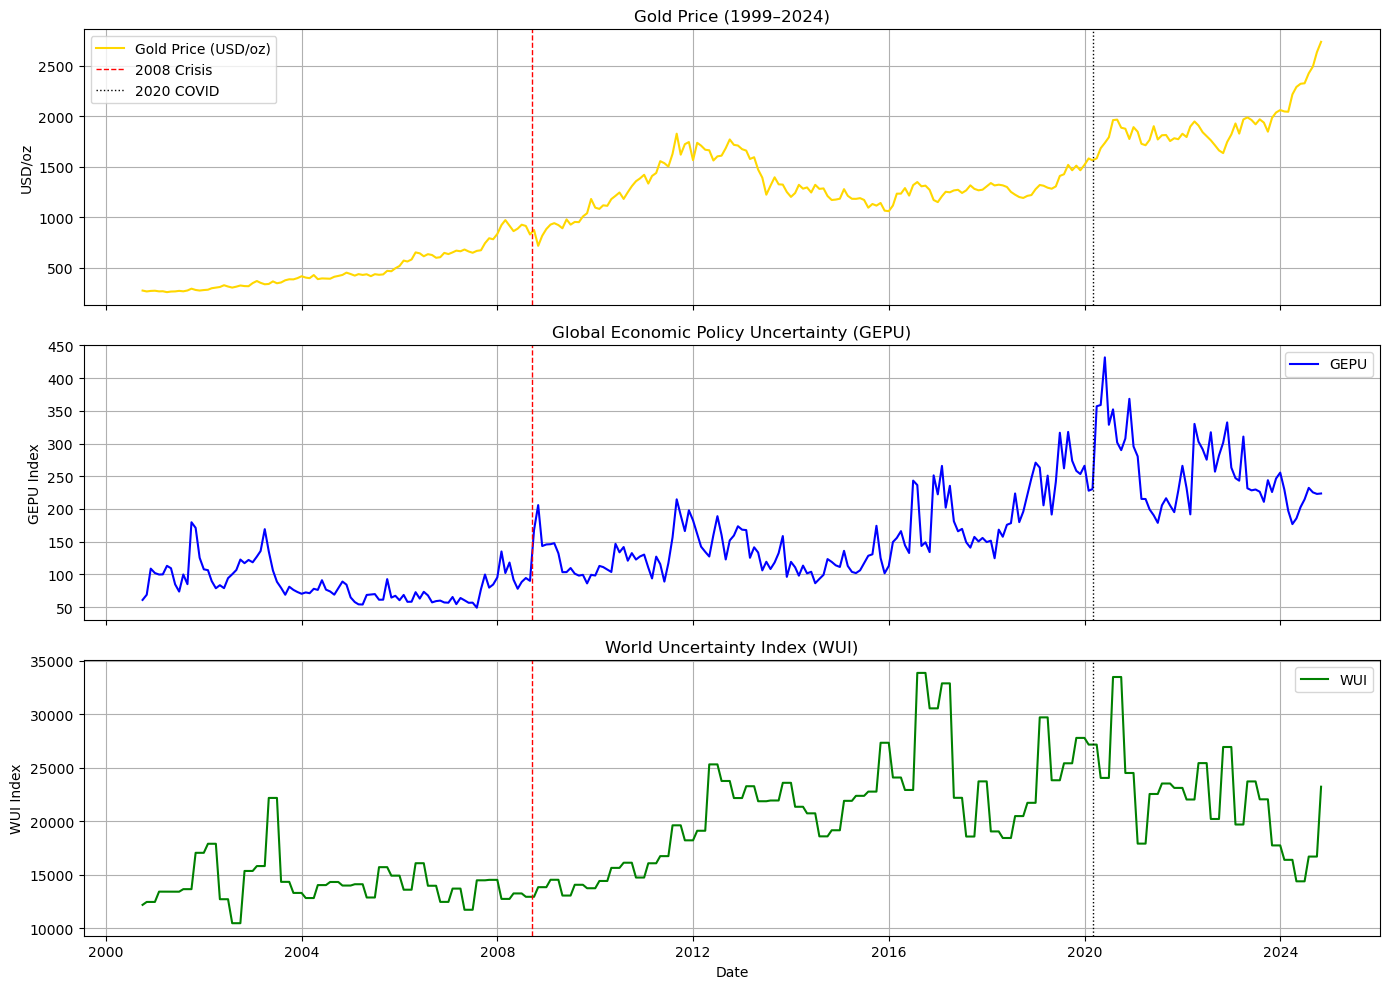

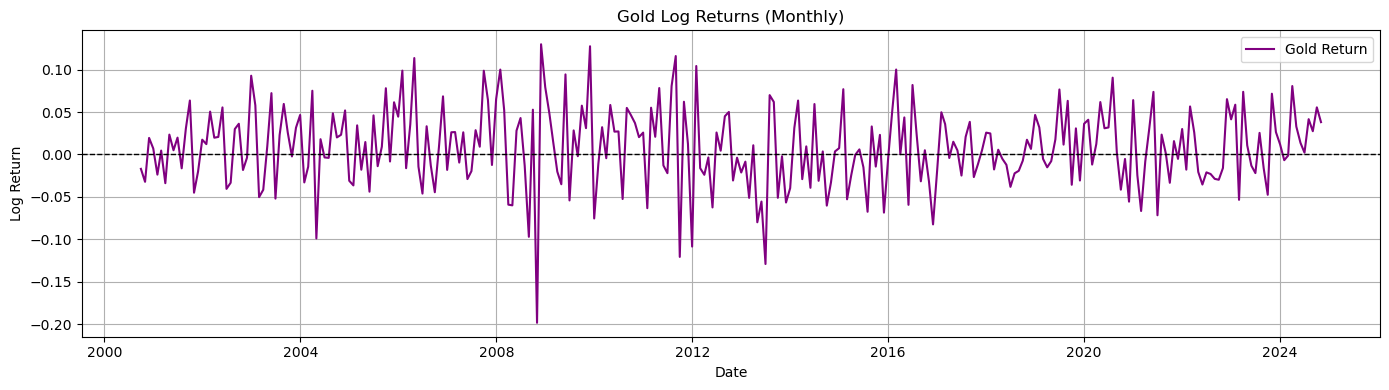

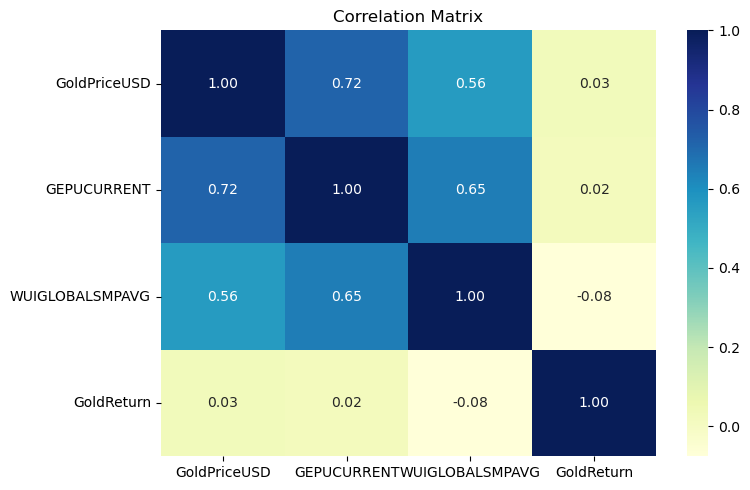

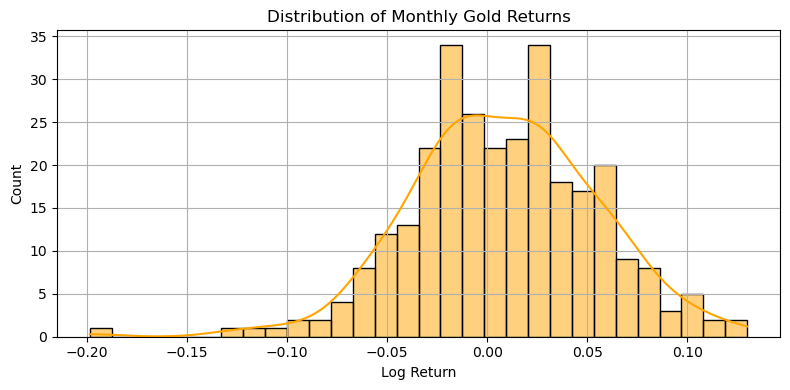

In [4]:

# Load the dataset
df = pd.read_csv("gold_uncertainty_dataset_monthly.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Set key crisis dates
crisis_2008 = pd.to_datetime("2008-09-15")  # Lehman collapse
covid_2020 = pd.to_datetime("2020-03-01")   # COVID outbreak impact starts

# Display basic info
print("\n Dataset Summary")
print(df.info())
print("\n Descriptive Statistics")
print(df.describe().T)

# Create the multi-panel time series plot
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Gold Price
axes[0].plot(df.index, df["GoldPriceUSD"], color='gold', label="Gold Price (USD/oz)")
axes[0].axvline(crisis_2008, color='red', linestyle='--', linewidth=1, label="2008 Crisis")
axes[0].axvline(covid_2020, color='black', linestyle=':', linewidth=1, label="2020 COVID")
axes[0].set_ylabel("USD/oz")
axes[0].set_title("Gold Price (1999–2024)")
axes[0].legend()
axes[0].grid(True)

# Plot 2: GEPU
axes[1].plot(df.index, df["GEPUCURRENT"], color='blue', label="GEPU")
axes[1].axvline(crisis_2008, color='red', linestyle='--', linewidth=1)
axes[1].axvline(covid_2020, color='black', linestyle=':', linewidth=1)
axes[1].set_ylabel("GEPU Index")
axes[1].set_title("Global Economic Policy Uncertainty (GEPU)")
axes[1].legend()
axes[1].grid(True)

# Plot 3: WUI
axes[2].plot(df.index, df["WUIGLOBALSMPAVG"], color='green', label="WUI")
axes[2].axvline(crisis_2008, color='red', linestyle='--', linewidth=1)
axes[2].axvline(covid_2020, color='black', linestyle=':', linewidth=1)
axes[2].set_ylabel("WUI Index")
axes[2].set_title("World Uncertainty Index (WUI)")
axes[2].legend()
axes[2].grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

# Gold Returns Plot
plt.figure(figsize=(14, 4))
plt.plot(df.index, df["GoldReturn"], color="purple", label="Gold Return")
plt.title("Gold Log Returns (Monthly)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#  Correlation Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

#  Distribution of Gold Returns
plt.figure(figsize=(8, 4))
sns.histplot(df["GoldReturn"], kde=True, color="orange", bins=30)
plt.title("Distribution of Monthly Gold Returns")
plt.xlabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:

# Load dataset
df = pd.read_csv("gold_uncertainty_dataset_monthly.csv", parse_dates=['Date'], index_col='Date')

# Define predictors and target
X = df[['GEPUCURRENT', 'WUIGLOBALSMPAVG']]
y = df['GoldReturn']

# Add constant (intercept)
X = sm.add_constant(X)

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Display results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             GoldReturn   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.997
Date:                Fri, 28 Mar 2025   Prob (F-statistic):              0.138
Time:                        16:41:56   Log-Likelihood:                 480.58
No. Observations:                 290   AIC:                            -955.2
Df Residuals:                     287   BIC:                            -944.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0219      0.010     

D:\Annaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Annaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Annaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\Annaconda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.wa

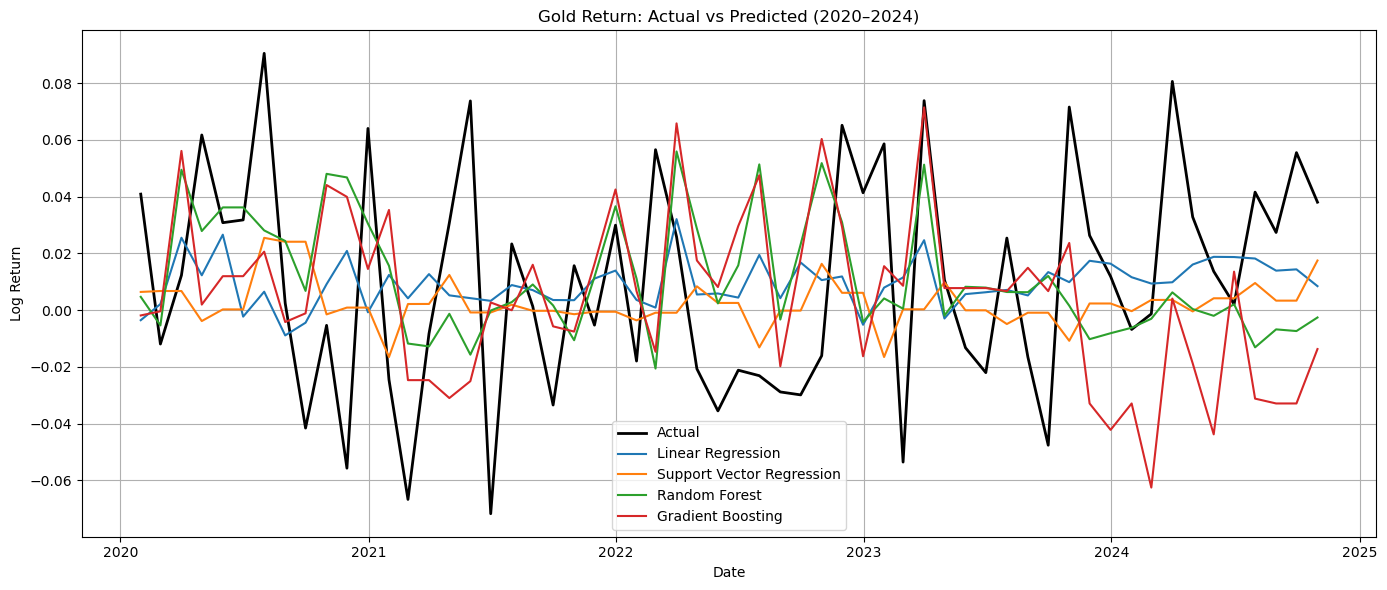


 Model Performance Summary:


,R2 Score,RMSE,MAE
Linear Regression,-0.012722,0.039563,0.033125
Support Vector Regression,-0.055729,0.040395,0.033019
Random Forest,-0.249438,0.043945,0.037116
Gradient Boosting,-0.596331,0.049672,0.043702


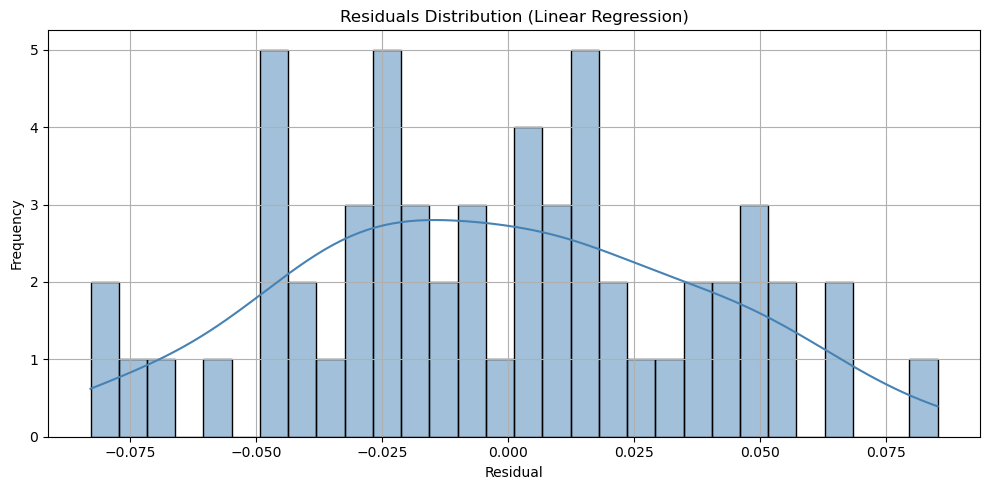

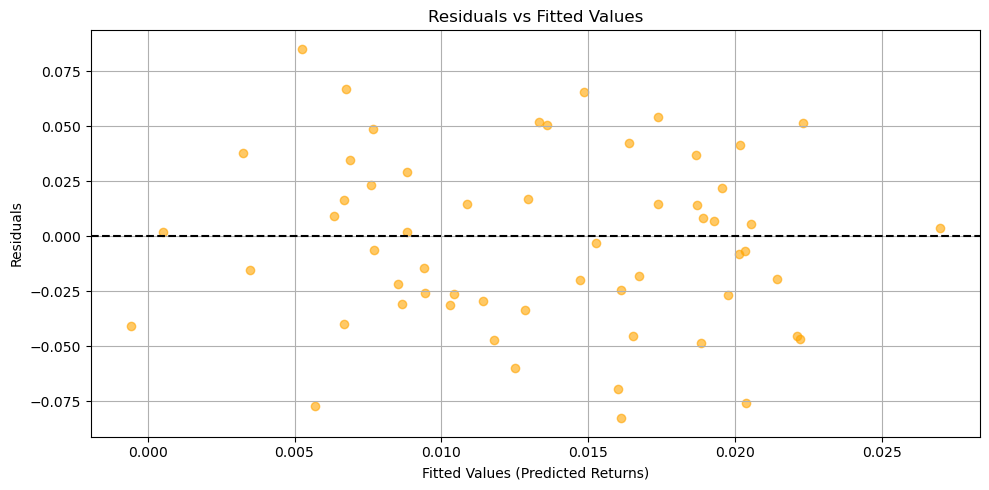

<Figure size 600x600 with 0 Axes>

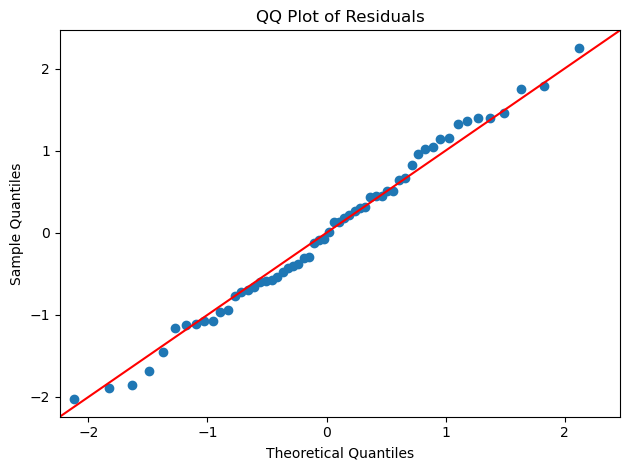

 Ljung-Box test for autocorrelation at lag 10:
     lb_stat  lb_pvalue
10  7.595298   0.668301


In [8]:

# Load the dataset
df = pd.read_csv("gold_uncertainty_dataset_monthly.csv", parse_dates=['Date'], index_col='Date')

# Create lagged features for uncertainty indices
df['GEPU_Lag1'] = df['GEPUCURRENT'].shift(1)
df['WUI_Lag1'] = df['WUIGLOBALSMPAVG'].shift(1)
df.dropna(inplace=True)

# Define features and target
X = df[['GEPUCURRENT', 'WUIGLOBALSMPAVG', 'GEPU_Lag1', 'WUI_Lag1']]
y = df['GoldReturn']

# Train-test split (80% train, 20% test, no shuffling for time-series)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Fit models and store results
results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    results[name] = {
        'R2 Score': r2_score(y_test, y_pred),
        'RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# Plot actual vs predicted returns
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black', linewidth=2)
for name, y_pred in predictions.items():
    plt.plot(y_test.index, y_pred, label=name)
plt.title("Gold Return: Actual vs Predicted (2020–2024)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Display metrics
results_df = pd.DataFrame(results).T
print("\n Model Performance Summary:")
display(results_df)



# Load dataset (update path if needed)
df = pd.read_csv("gold_uncertainty_dataset_monthly.csv", parse_dates=['Date'], index_col='Date')

#  Features and Target
X = df[['GEPUCURRENT', 'WUIGLOBALSMPAVG']]
y = df['GoldReturn']

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions_lr = lr.predict(X_test)

#  Residuals
residuals = y_test - predictions_lr

# 1. Residuals Distribution
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='steelblue')
plt.title("Residuals Distribution (Linear Regression)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#  2. Residuals vs Fitted
plt.figure(figsize=(10, 5))
plt.scatter(predictions_lr, residuals, color='orange', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values (Predicted Returns)")
plt.ylabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

#  3. QQ Plot
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.tight_layout()
plt.show()

# 4. Ljung-Box Test
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(" Ljung-Box test for autocorrelation at lag 10:")
print(ljung_box_result)



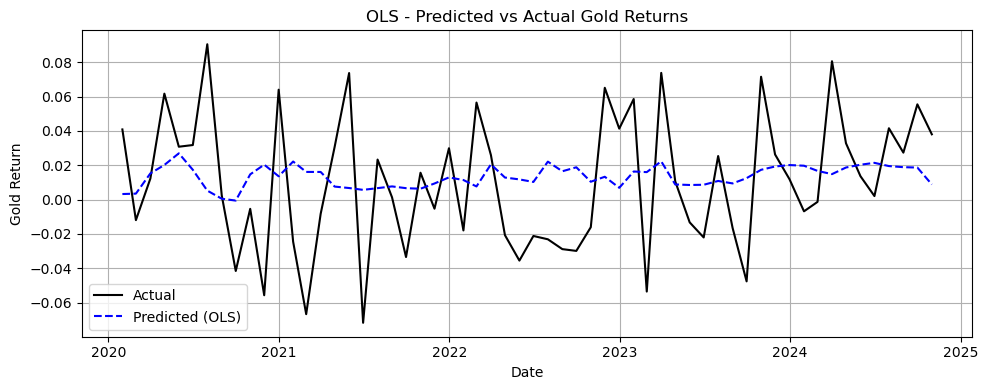

{'Model': 'OLS', 'MSE': 0.0015538300512180085, 'MAE': 0.03273698342546765, 'R²': -0.005325121498153562}


In [10]:

# Fit OLS Model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
ols_pred = ols_model.predict(X_test)

# Evaluation Metrics
ols_results = {
    "Model": "OLS",
    "MSE": mean_squared_error(y_test, ols_pred),
    "MAE": mean_absolute_error(y_test, ols_pred),
    "R²": r2_score(y_test, ols_pred)
}

# Plotting Predicted vs Actual
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test, label='Actual', color='black')
plt.plot(y_test.index, ols_pred, label='Predicted (OLS)', linestyle='--', color='blue')
plt.title("OLS - Predicted vs Actual Gold Returns")
plt.xlabel("Date")
plt.ylabel("Gold Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print evaluation results
print(ols_results)


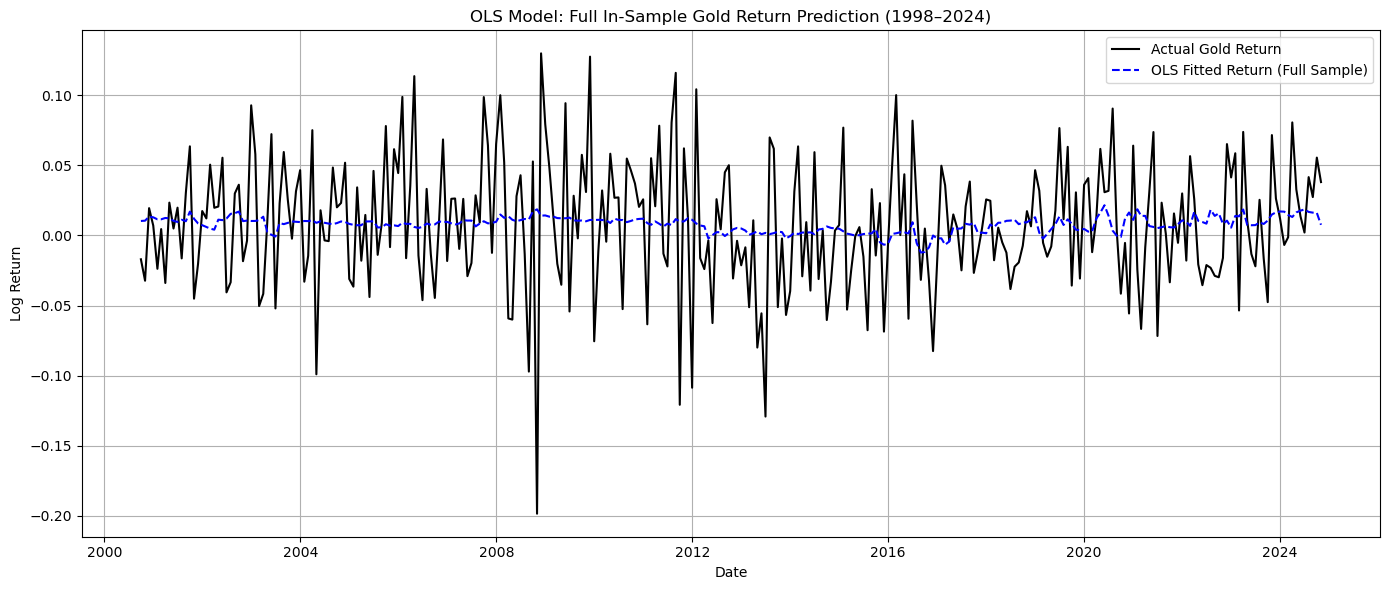

In [12]:


# Load your full dataset
df = pd.read_csv("gold_uncertainty_dataset_monthly.csv", parse_dates=['Date'], index_col='Date')

# Select features and target
X_full = df[['GEPUCURRENT', 'WUIGLOBALSMPAVG']]
y_full = df['GoldReturn']

# Fit OLS on the full dataset
ols_full = LinearRegression()
ols_full.fit(X_full, y_full)

# Predict in-sample values
ols_full_preds = ols_full.predict(X_full)

# Plot actual vs fitted over full timeline
plt.figure(figsize=(14, 6))
plt.plot(df.index, y_full, label='Actual Gold Return', color='black')
plt.plot(df.index, ols_full_preds, label='OLS Fitted Return (Full Sample)', linestyle='--', color='blue')
plt.title("OLS Model: Full In-Sample Gold Return Prediction (1998–2024)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


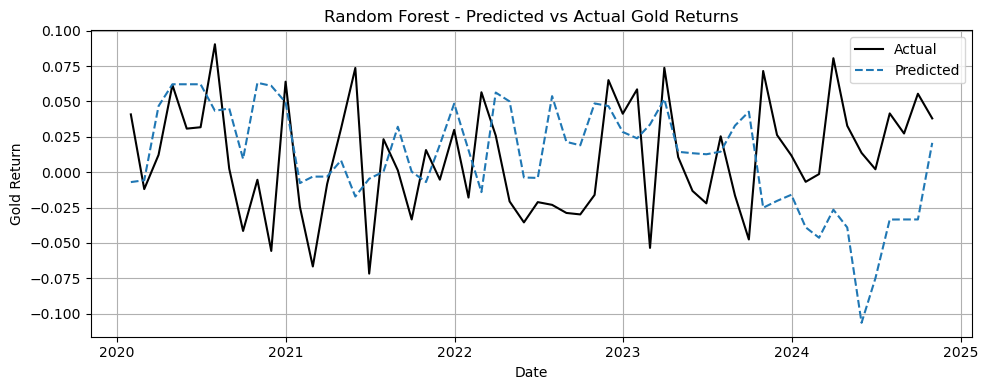

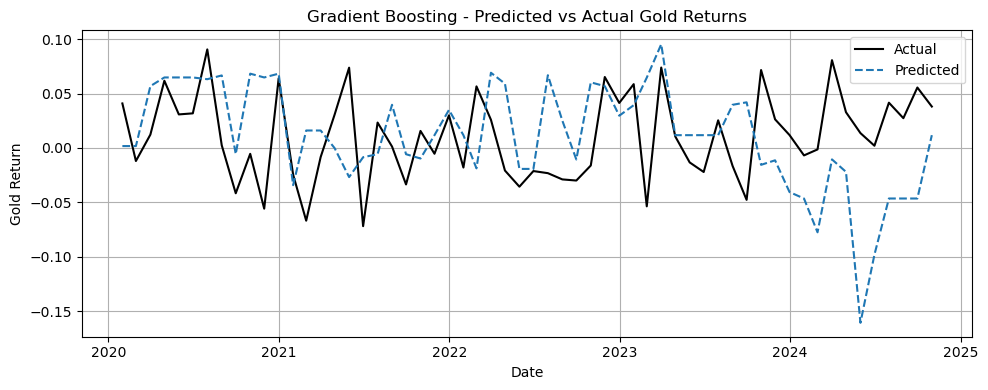

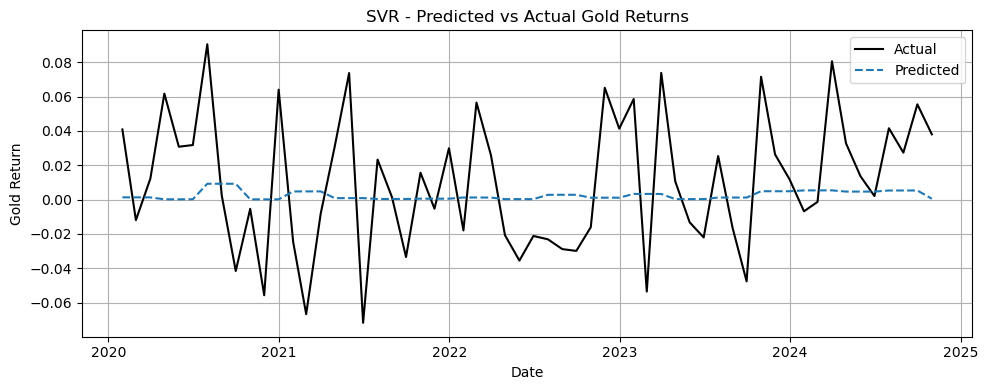

""


In [18]:


# Features and target
X = df[['GEPUCURRENT', 'WUIGLOBALSMPAVG']]
y = df['GoldReturn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

# Store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Plot predictions vs actuals
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test, label='Actual', color='black')
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
    plt.title(f"{name} - Predicted vs Actual Gold Returns")
    plt.xlabel("Date")
    plt.ylabel("Gold Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Show performance comparison
results_df = pd.DataFrame(results)
display(results_df)


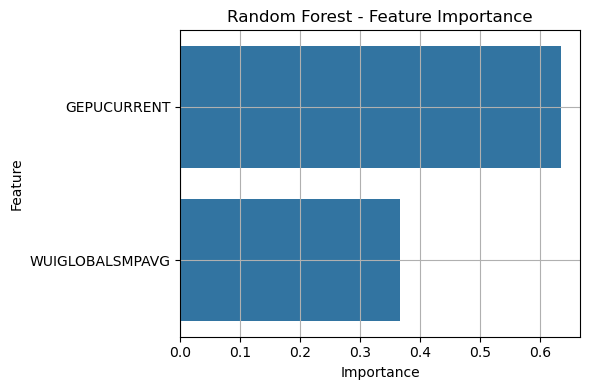

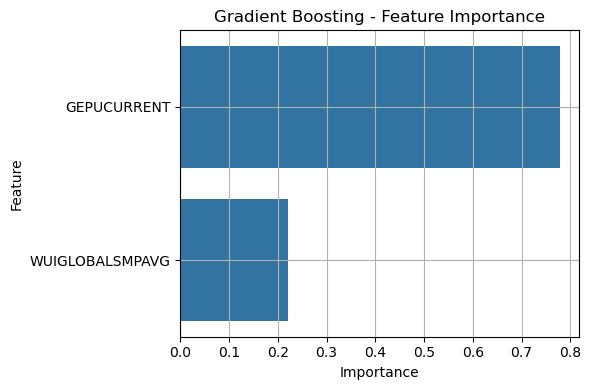

In [20]:
# Feature importance (for tree-based models only)
for name in ["Random Forest", "Gradient Boosting"]:
    model = models[name]
    importances = model.feature_importances_

    plt.figure(figsize=(6, 4))
    sns.barplot(x=importances, y=X.columns)
    plt.title(f"{name} - Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


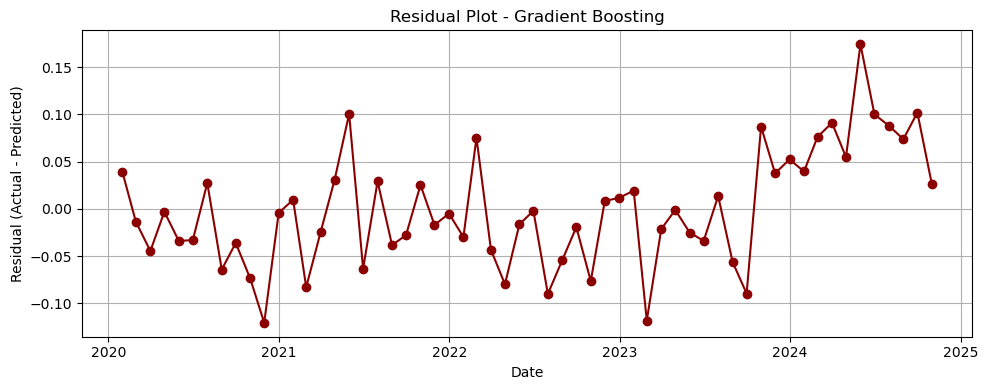

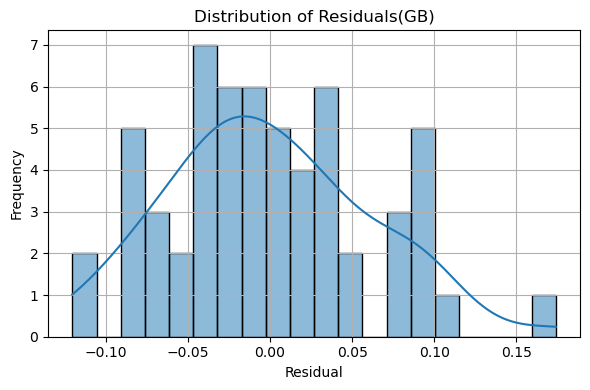

In [22]:
# Residuals
best_model = models["Gradient Boosting"]
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, residuals, marker='o', linestyle='-', color='darkred')
plt.title("Residual Plot - Gradient Boosting")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=20)
plt.title("Distribution of Residuals(GB)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid(True)
plt.show()


In [24]:
import pandas as pd

# Load your existing monthly dataset
df = pd.read_csv("gold_uncertainty_dataset_monthly.csv", parse_dates=['Date'], index_col='Date')

# Create lagged variables (1-month lag)
df['GEPU_Lag1'] = df['GEPUCURRENT'].shift(1)
df['WUI_Lag1'] = df['WUIGLOBALSMPAVG'].shift(1)

# Drop missing rows due to lag
df.dropna(inplace=True)

# Save new lagged dataset
df.to_csv("gold_uncertainty_dataset_lagged.csv")
print(" Lagged dataset saved as 'gold_uncertainty_dataset_lagged.csv'")


 Lagged dataset saved as 'gold_uncertainty_dataset_lagged.csv'


In [26]:
import statsmodels.api as sm

# Define predictors and target
X_lagged = df[['GEPU_Lag1', 'WUI_Lag1']]
y_lagged = df['GoldReturn']

# Add constant term
X_lagged = sm.add_constant(X_lagged)

# Fit OLS model
model_lagged = sm.OLS(y_lagged, X_lagged).fit()

# Display summary
print(model_lagged.summary())


                            OLS Regression Results                            
Dep. Variable:             GoldReturn   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.473
Date:                Fri, 28 Mar 2025   Prob (F-statistic):              0.231
Time:                        16:43:29   Log-Likelihood:                 478.05
No. Observations:                 289   AIC:                            -950.1
Df Residuals:                     286   BIC:                            -939.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0229      0.010      2.271      0.0

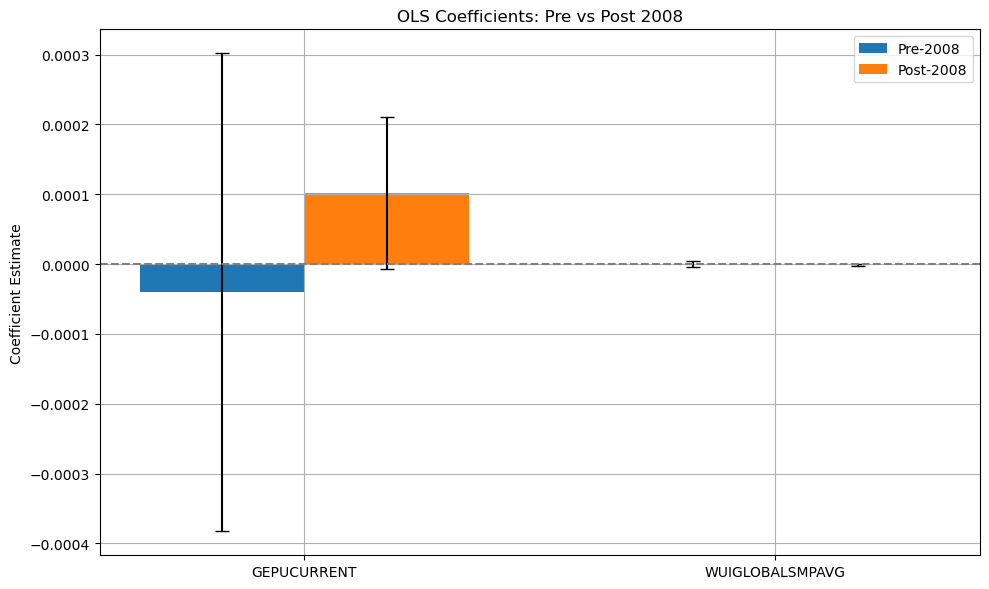

In [28]:

# Load your lagged dataset
df_lagged = pd.read_csv("gold_uncertainty_dataset_lagged.csv", parse_dates=["Date"], index_col="Date")
df_lagged.dropna(inplace=True)

# Split data
pre_2008 = df_lagged[df_lagged.index < '2008-01-01']
post_2008 = df_lagged[df_lagged.index >= '2008-01-01']

# Fit OLS models
X_pre = sm.add_constant(pre_2008[['GEPUCURRENT', 'WUIGLOBALSMPAVG']])
y_pre = pre_2008['GoldReturn']
model_pre_2008 = sm.OLS(y_pre, X_pre).fit()

X_post = sm.add_constant(post_2008[['GEPUCURRENT', 'WUIGLOBALSMPAVG']])
y_post = post_2008['GoldReturn']
model_post_2008 = sm.OLS(y_post, X_post).fit()

# Build dataframe for plotting
coef_data = {
    "Variable": ["GEPUCURRENT", "WUIGLOBALSMPAVG"],
    "Pre-2008": [model_pre_2008.params["GEPUCURRENT"], model_pre_2008.params["WUIGLOBALSMPAVG"]],
    "Post-2008": [model_post_2008.params["GEPUCURRENT"], model_post_2008.params["WUIGLOBALSMPAVG"]],
    "Pre-2008 CI Low": [model_pre_2008.conf_int().loc["GEPUCURRENT"][0], model_pre_2008.conf_int().loc["WUIGLOBALSMPAVG"][0]],
    "Pre-2008 CI High": [model_pre_2008.conf_int().loc["GEPUCURRENT"][1], model_pre_2008.conf_int().loc["WUIGLOBALSMPAVG"][1]],
    "Post-2008 CI Low": [model_post_2008.conf_int().loc["GEPUCURRENT"][0], model_post_2008.conf_int().loc["WUIGLOBALSMPAVG"][0]],
    "Post-2008 CI High": [model_post_2008.conf_int().loc["GEPUCURRENT"][1], model_post_2008.conf_int().loc["WUIGLOBALSMPAVG"][1]],
}

df_coef = pd.DataFrame(coef_data)

# Plot
x = range(len(df_coef))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - width/2 for i in x], df_coef["Pre-2008"], width=width,
        yerr=[df_coef["Pre-2008"] - df_coef["Pre-2008 CI Low"],
              df_coef["Pre-2008 CI High"] - df_coef["Pre-2008"]],
        capsize=5, label="Pre-2008")

plt.bar([i + width/2 for i in x], df_coef["Post-2008"], width=width,
        yerr=[df_coef["Post-2008"] - df_coef["Post-2008 CI Low"],
              df_coef["Post-2008 CI High"] - df_coef["Post-2008"]],
        capsize=5, label="Post-2008")

plt.xticks(x, df_coef["Variable"])
plt.ylabel("Coefficient Estimate")
plt.title("OLS Coefficients: Pre vs Post 2008")
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
